# Use a local ipyparallel cluster

Start the controller and some engines:

1. In a terminal start your controller with `ipcontroller`:
```shell
$ ipcontroller
```

2. In another terminal start your engines with `ipcluster`:
```shell
$ ipcluster engines -n 8
```

IPython Parallel structure:

<img src="https://ipyparallel.readthedocs.io/en/latest/_images/wideView.png" alt='ipyparallel' style="width: 300px;"/>

### 1. Install development versions of Joblib and IPython parallel

In [ ]:
import subprocess

subprocess.check_call(
    'pip install git+https://github.com/ipython/ipyparallel'.split())
subprocess.check_call(
    'pip install git+https://github.com/joblib/joblib'.split())

### 2. Monkey patch internal joblib in scikit-learn

In [1]:
# Force the use of the development branch of joblib in scikit-learn
# won't be necessary once scikit-learn will get in sync with joblib
# 0.10+
import joblib
from sklearn.externals import joblib as skl_joblib
print('Monkeypatching scikit-learn embedded joblib')
for k, v in vars(joblib).items():
   setattr(skl_joblib, k, v)

Monkeypatching scikit-learn embedded joblib


### 3. Parameter search with scikit-learn

In [2]:
from sklearn.datasets import load_digits

digits = load_digits()

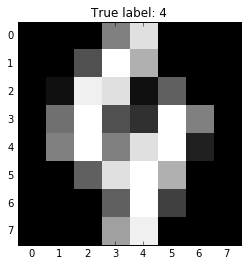

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt

sample_idx = 124
plt.imshow(digits.data[sample_idx].reshape(8, 8), interpolation='nearest',
           cmap=plt.cm.gray)
plt.title("True label: %d" % digits.target[sample_idx]);

In [4]:
from sklearn.grid_search import RandomizedSearchCV
from sklearn.svm import SVC
import numpy as np
from pprint import pprint

model = SVC(kernel='rbf')

param_space = {
    'C': np.logspace(-6, 6, 13),
    'gamma': np.logspace(-8, 8, 17),
    'tol': np.logspace(-4, -1, 4),
    'class_weight': [None, 'balanced'],
}

<img src="random_search_1.png" alt="ec2" style="width: 480px;"/><br>
<p align="right">Credits: Gael Varoquaux</p>

## Run using single job

In [5]:
%%time
search = RandomizedSearchCV(model, param_space, cv=2, random_state=0, n_iter=1)
search.fit(digits.data, digits.target)

print("Best parameter score: %0.3f" % search.best_score_)
pprint(search.best_params_)

Best parameter score: 0.200
{'C': 0.10000000000000001,
 'class_weight': None,
 'gamma': 9.9999999999999995e-08,
 'tol': 0.0001}
CPU times: user 1.03 s, sys: 0 ns, total: 1.03 s
Wall time: 1.03 s


## Run using the ipyparallel cluster

In [6]:
import ipyparallel as ipp
from ipyparallel.joblib import IPythonParallelBackend
from joblib import parallel_backend, register_parallel_backend
register_parallel_backend('ipyparallel', IPythonParallelBackend)

In [7]:
%%time
with parallel_backend('ipyparallel'):
    search = RandomizedSearchCV(model, param_space, cv=2, n_iter=5, random_state=0, verbose=10)
    search.fit(digits.data, digits.target)

[Parallel(n_jobs=-1)]: Done   3 out of  10 | elapsed:    1.7s remaining:    4.0s
[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed:    1.7s remaining:    1.7s
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:    1.8s remaining:    0.8s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    1.9s finished


Fitting 2 folds for each of 5 candidates, totalling 10 fits
CPU times: user 236 ms, sys: 4 ms, total: 240 ms
Wall time: 2.06 s


In [8]:
print("Best parameter score: %0.3f" % search.best_score_)
pprint(search.best_params_)

Best parameter score: 0.963
{'C': 1000000.0, 'class_weight': None, 'gamma': 0.001, 'tol': 0.001}
